# E(n) Equivariant Models

In this tutorial, we'll go over the following topics:
- Implementing the E(n) GNN by Satorras, et al. [3]
- (Equivariance) Unit testing

The first half of the tutorial builds the solution Translational model from the last practical, the second half is the good part.

We will build the E(n) GNN [3] from scratch, and briefly explain how it works. For a more in-depth explanation, read the original paper [3].

In [5]:
import torch 
import torch_geometric
from torch_geometric.data import Data, DataLoader, InMemoryDataset
import numpy as np
import matplotlib.pyplot as plt
import os

## Data exploration

First let's look at the data structure, and some statistics.

In [6]:
trajectories = [np.load(f"../data/boids/raw/{f}") for f in os.listdir("../data/boids/raw") if f.endswith(".npy")]
print(len(trajectories))

26


In [9]:
def plot_state(trajectory, timestep):
    fig, ax = plt.subplots()
    # Plot dots for the boids
    ax.scatter(trajectory[timestep, :, 0], trajectory[timestep, :, 1])
    # plot the boid velocities as arrows
    for i in range(trajectory.shape[1]):
        # NOTE: The arrows are made larger for effect
        ax.arrow(trajectory[timestep, i, 0], trajectory[timestep, i, 1], trajectory[timestep, i, 2]*5, trajectory[timestep, i, 3]*5)
    return ax

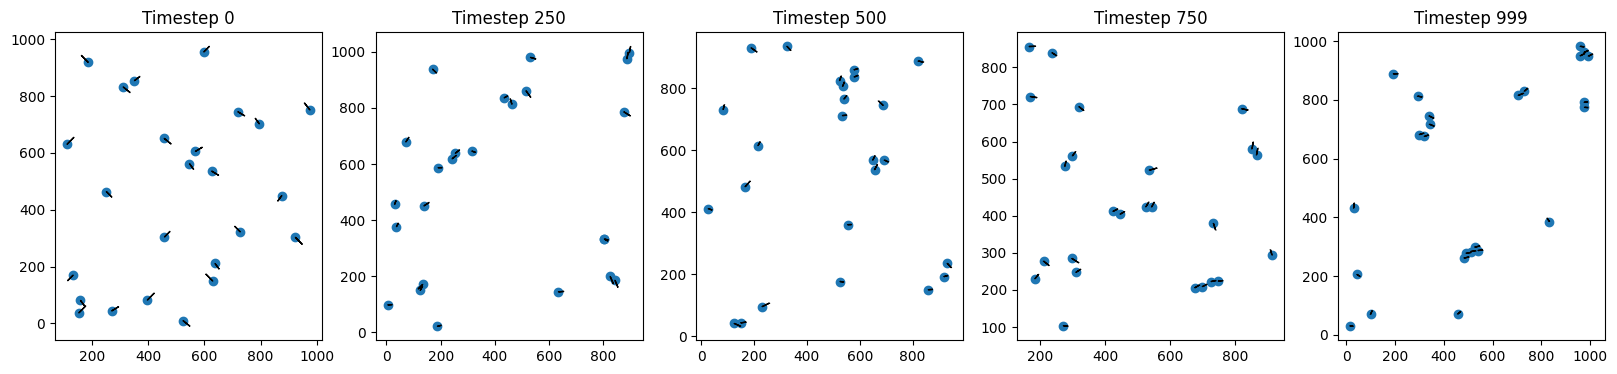

In [10]:
# Plot timesteps 0, 250, 500, 750, 999 for the first trajectory
trajectory = trajectories[0]
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, t in enumerate([0, 250, 500, 750, 999]):
    axs[i].set_title(f"Timestep {t}")
    # Plot dots for the boids
    axs[i].scatter(trajectory[t, :, 0], trajectory[t, :, 1])
    # plot the boid velocities as arrows
    for j in range(trajectory.shape[1]):
        # NOTE: The arrows are made larger for effect
        axs[i].arrow(trajectory[t, j, 0], trajectory[t, j, 1], trajectory[t, j, 2]*5, trajectory[t, j, 3]*5)
plt.show()

In the plot above, you can see that after some warmup time, the boids start to form flocks. Flocking behavior is a form of inter-node communication, which we will come back to again later.

Thinking back to the Geometric Deep Learning framework, we can identify the following symmetries in the data:

- The boids are equivariant to permutations, ie it does not matter in which order we compute the update rules for the boids.
- Local flocks of boids are equivariant to translation, rotation and reflection. 

Following these symmetries, it makes sense to model the boids using a Graph Neural Network (GNN). Specifically, since we are dealing with inter-node communication, we will be implementing a Message Passing GNN here.

But first, we create a `torch_geometric` InMemoryDataset object, to model the data as a graph.

In [11]:
class Trainer:
    def __init__(self, model, train_dataset, validation_dataset, batch_size=1, lr=0.0001, epochs=100, loss_fn=torch.nn.MSELoss(), model_name= "01-AR-Set-Model.pt"):
        """
        Simple Trainer class to train a PyTorch (geometric) model on a dataset.

        Args:
            model: PyTorch model to train
            train_dataset: PyTorch dataset to train on
            validation_dataset: PyTorch dataset to validate on
            batch_size: Batch size for training
            lr: Learning rate
            epochs: Number of epochs to train for
            loss_fn: Loss function to use
        """
        self.model = model
        self.train_dataset = train_dataset
        self.validation_dataset = validation_dataset
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.loss_fn = loss_fn
        self.model_name = model_name

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("Using device:", self.device)
        self.model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        self.train_loader = self.make_data_loader(self.train_dataset)
        self.validation_loader = self.make_data_loader(self.validation_dataset, shuffle=False)

    def make_data_loader(self, dataset, shuffle=True):
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)

    def train_loop(self):
        """
        Train loop for the model
        """
        best_model_loss = np.inf
        for epoch in range(self.epochs):
            # Train the model
            self.model.train()
            mean_train_loss = 0
            for i, data in enumerate(self.train_loader):
                data = self.train_dataset[i].to(self.device)
                self.optimizer.zero_grad()
                out = self.model(data)
                loss = self.loss_fn(out, data.y)
                loss.backward()
                self.optimizer.step()
                mean_train_loss += loss.item()
            mean_train_loss /= i
            
            # Validate the model
            self.model.eval()
            mean_val_loss = 0
            with torch.no_grad():
                for i, data in enumerate(self.validation_loader):
                    data = self.validation_dataset[i].to(self.device)
                    out = self.model(data)
                    loss = self.loss_fn(out, data.y)
                    mean_val_loss += loss.item()
                mean_val_loss /= i

            if mean_val_loss < best_model_loss:
                best_model_loss = mean_val_loss
                torch.save(self.model.state_dict(), f"../models/{self.model_name}")
            
            print(f"Epoch {epoch}, Mean Train Loss: {mean_train_loss}, Mean Validation Loss: {mean_val_loss}")



### Quick recap on equivariances

<img src="figures/boids-translational-equivariance.png" alt="drawing" width="250" style="background-color: white; padding: 50px;"/>
<img src="figures/boids-rotational-equivariance.png" alt="drawing" width="250" style="background-color: white; padding: 50px;"/>

The figures above show the equivariances of the Boids system. The system is equivariant to all E(n) transformations; translation,
rotation and reflection.*

Formally, we say a function $f: X \rarr Y$ is _equivariant_ to a group action or transformation $T: X \rarr X$ if there is an equivalent transformation $S: Y \rarr Y$ on the output space of the function such that

$f(T(x)) = S(f(x))$ for each $x \in X$

We won't go into the formal definitions of each equivariance, but if you're interested you can check out the [E(n) Equivariant Graph Neural Networks](https://arxiv.org/pdf/2102.09844) paper [3], the equivariant model is based on. 

*: Excluding time translation equivariance, which states that there is no dependence on the time of the system, only the state.

*: Also excluding permutational equivariance; the order of the nodes does not matter.

## Towards Equivariant AR-GNNs
The above model is **not** equivariant to translations in space! This is because we use absolute coordinates as _node features_, which creates a dependence on the absolute coordinate system. Instead, if we do not use the absolute positions as node features - and include the PBC distance as _edge features_ - the predictions will be space translation equivariant.

Let's implement this!

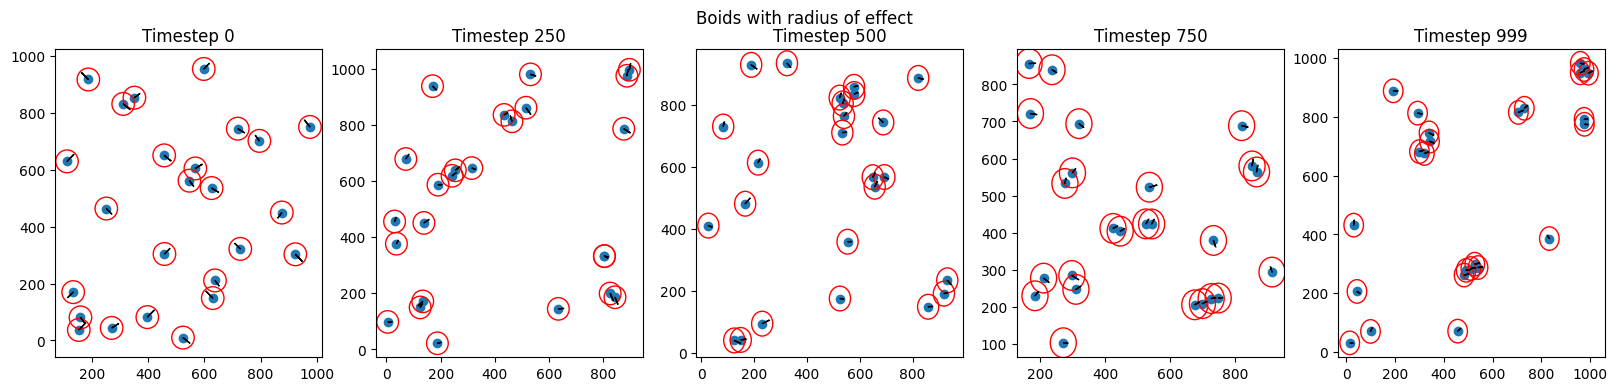

In [12]:
# Plot timesteps 0, 250, 500, 750, 999 for the first trajectory
trajectory = trajectories[0]
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle("Boids with radius of effect")
radius = 40

for i, t in enumerate([0, 250, 500, 750, 999]):
    axs[i].set_title(f"Timestep {t}")
    # Plot dots for the boids
    axs[i].scatter(trajectory[t, :, 0], trajectory[t, :, 1])
    # Draw a red circle around each boid to indicate the radius
    for j in range(trajectory.shape[1]):
        circle = plt.Circle((trajectory[t, j, 0], trajectory[t, j, 1]), radius, color='r', fill=False)
        axs[i].add_artist(circle)
    # plot the boid velocities as arrows
    for j in range(trajectory.shape[1]):
        # NOTE: The arrows are made larger for effect
        axs[i].arrow(trajectory[t, j, 0], trajectory[t, j, 1], trajectory[t, j, 2]*5, trajectory[t, j, 3]*5)
plt.show()

Above, we show the boids with their radius of effect. As expected, boids who are farther than `radius=40` units away from eachother, are shown to not affect eachother. 

For simplicity's sake, we will assign a weight of 0 to edges* between boids that are further than 40 units away from eachother (using the PBC distance), and the PBC distance for edges between boids within the 40 units.

*: Added in the model forward pass. Not best practice, but recomputing the distances takes forever `¯\_(ツ)_/¯`.

In [133]:
from tqdm import trange

class AR_Boids_Dataset(InMemoryDataset):
    def __init__(self, raw_data_path, processed_data_path, root=None, transform=None, pre_transform=None, post_transform=None, solution_idx_range=(0, 25), timesteps=1000, processed_file_name="AR1_Boids.pt", L = 1000):
        self.raw_data_path = raw_data_path
        self.processed_data_path = processed_data_path
        self.solution_idx_range = solution_idx_range
        self.timesteps = timesteps
        self.processed_file_name = processed_file_name
        self.pre_transform = pre_transform
        self.transform = transform
        self.post_transform = post_transform
        self.L = L
        super(AR_Boids_Dataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return [self.processed_file_name]

    @property
    def raw_file_names(self):
        return [pfn for pfn in os.listdir(self.raw_data_path) if (self.solution_idx_range[0] <= int(pfn.split("_")[-1][:-4]) < self.solution_idx_range[1])]
    
    def download(self):
        pass
    
    def __len__(self):
        return (self.timesteps - 1) * (self.solution_idx_range[1] - self.solution_idx_range[0])

    def pbc_distance(self, x1, x2, y1, y2):
        """
        Compute the distance between two points with periodic boundary conditions

        Args:
            x1 (float): x coordinate of point 1
            x2 (float): x coordinate of point 2
            y1 (float): y coordinate of point 1
            y2 (float): y coordinate of point 2
        
        Returns:
            float: Distance between the two points
        """
        dx = torch.abs(x1 - x2)
        dy = torch.abs(y1 - y2)
        dx = torch.min(dx, self.L - dx)
        dy = torch.min(dy, self.L - dy)
        return torch.sqrt(dx**2 + dy**2)

    def process(self):
        positions_list = []
        data_list = []
        for idx, raw_path in enumerate(self.raw_file_names):
            trajectory = np.load(self.raw_data_path + raw_path)

            if self.transform is not None:
                trajectory = self.transform(trajectory)
                
            # Add the initial positions to the positions list
            positions_list.append(trajectory[0, :, :2])

            for t in trange(trajectory.shape[0] - 1):
                # X is the current state: (Velocity x, Velocity y)
                # Y is the next state: (Delta Pos x, Delta Pos y, Delta Velocity x, Delta Velocity y)
                x = torch.tensor(trajectory[t], dtype=torch.float)
                y_temp = torch.tensor(trajectory[t+1], dtype=torch.float)
                # Right now y is (position x, position y, velocity x, velocity y) for the next timestep
                # However, we want delta position and delta velocity
                # Luckily, the delta poisition is just the velocity from the next timestep, and the delta velocity is the acceleration
                # So we can just take the last two elements of y to get the delta velocity
                # First we copy the last two columns of y to the first two columns of y
                y = y_temp.clone()
                y[:, :2] = y_temp[:, 2:]
                # Then we calculate the acceleration
                y[:, 2:] = y_temp[:, 2:] - x[:, 2:]
                edge_index = torch.tensor([[i, j] for i in range(trajectory.shape[1]) for j in range(trajectory.shape[1]) if i != j], dtype=torch.long).t().contiguous()
                edge_attr = torch.tensor([[self.pbc_distance(x[i, 0], x[j, 0], x[i, 1], x[j, 1])] for i in range(trajectory.shape[1]) for j in range(trajectory.shape[1]) if i != j], dtype=torch.float).t().contiguous()
                
                x = x[:, 2:]

                if self.post_transform is not None:
                    data = self.post_transform(data)
                
                data = Data(x=x, y=y, edge_index=edge_index, edge_attr=edge_attr)
                data_list.append(data)
                
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_data_path+self.processed_file_name)
        torch.save(torch.tensor(positions_list), self.processed_data_path+"positions_"+self.processed_file_name)

    def __getitem__(self, idx):
        return self.get(idx)
    
    def __repr__(self):
        return f'{self.__class__.__name__}({len(self)})'

In [166]:
equivariant_train_dataset = AR_Boids_Dataset(
    raw_data_path="../data/boids/raw/", 
    processed_data_path="../data/boids/processed/", 
    root="../data/boids/", 
    solution_idx_range=(0, 15), 
    timesteps=1000, 
    processed_file_name="AR1_Boids_Equivariant.pt"
    )

equivariant_validation_dataset = AR_Boids_Dataset(
    raw_data_path="../data/boids/raw/", 
    processed_data_path="../data/boids/processed/", 
    root="../data/boids/", 
    solution_idx_range=(16, 25), 
    timesteps=1000, 
    processed_file_name="AR1_VAL_Boids_Equivariant.pt"
    )

In [15]:
init_positions = torch.load("../data/boids/processed/positions_AR1_Boids_Equivariant.pt")
print(init_positions.shape)
init_val_positions = torch.load("../data/boids/processed/positions_AR1_VAL_Boids_Equivariant.pt")
print(init_val_positions.shape)

torch.Size([15, 25, 2])
torch.Size([9, 25, 2])


In [16]:
class TranslationalEquivariantModel(torch.nn.Module):
    def __init__(self, node_dim=2, emb_dim=16, out_dim=4):
        """
        Graph Neural Network that is equivariant to translations.

        Args:
            node_dim: Dimension of the node features
            emb_dim: Dimension of the node embeddings
            out_dim: Dimension of the output
        """
        super(TranslationalEquivariantModel, self).__init__()
        self.node_embedding = torch.nn.Linear(node_dim, emb_dim)
        self.conv1 = torch_geometric.nn.GCNConv(emb_dim, emb_dim, aggr='add')
        self.conv2 = torch_geometric.nn.GCNConv(emb_dim, out_dim, aggr='add')

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        edge_attr = edge_attr.view(-1)
        x = self.node_embedding(x)
        x = torch.nn.functional.relu(x)

        # If the edge attr > 40, set the edge attr to 0
        edge_attr[edge_attr > 40] = 0

        x = self.conv1(x, edge_index, edge_weight=edge_attr)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x, edge_index, edge_weight=edge_attr)
        return x

In [17]:
translational_equivariant_model = TranslationalEquivariantModel(emb_dim=64)
trainer = Trainer(translational_equivariant_model, equivariant_train_dataset, equivariant_validation_dataset, batch_size=8, loss_fn=torch.nn.MSELoss(), epochs=100, model_name="02-Translational-Equivariant-Model.pt")
trainer.train_loop()

Using device: cuda


c:\Users\alec\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0, Mean Train Loss: 0.2725746356464477, Mean Validation Loss: 0.071085742094039
Epoch 1, Mean Train Loss: 0.045656435420919156, Mean Validation Loss: 0.06943064274418542
Epoch 2, Mean Train Loss: 0.04480708010007387, Mean Validation Loss: 0.06947166667003035
Epoch 3, Mean Train Loss: 0.04457225229839314, Mean Validation Loss: 0.06890024216826972


KeyboardInterrupt: 

In [20]:
def model2_rollouts(model, dataset, positions_dataset, timesteps=1000, device='cuda', mode="residual", width = 1000, height = 1000):
    """
    Predict the rollouts of the model on the dataset starting from the idx

    Args:
        model: PyTorch model
        dataset: PyTorch dataset
        positions_dataset: PyTorch dataset containing the initial positions
        timesteps: Number of timesteps to predict
    """
    model.eval()
    with torch.no_grad():
        rollouts = []
        for i in range(len(dataset)):
            data = dataset[i].to(device)
            rollout = [data.x]
            node_positions = positions_dataset[i].to(device)
            for t in range(timesteps - 1):
                out = model(data)
                if mode == "residual":
                    current_velocities = data.x
                    current_velocities += out[:, 2:]

                    # Ensure the velocities are within the range [-6, 6]
                    current_velocities[:, 0] = torch.clamp(current_velocities[:, 0], -6, 6)
                    current_velocities[:, 1] = torch.clamp(current_velocities[:, 1], -6, 6)

                    data.x = current_velocities
                    rollout.append(current_velocities)

                    # Update the positions
                    node_positions += current_velocities
                    # Update the positions to be within the range [0, width] and [0, height]
                    node_positions[:, 0] = node_positions[:, 0] % width
                    node_positions[:, 1] = node_positions[:, 1] % height
                    
                    # Update the edge attributes
                    edge_attr = torch.tensor([[dataset.pbc_distance(node_positions[i, 0], node_positions[j, 0], node_positions[i, 1], node_positions[j, 1])] for i in range(node_positions.shape[0]) for j in range(node_positions.shape[0]) if i != j], dtype=torch.float).t().contiguous()
                    data.edge_attr = edge_attr.to(device)
                    
                else:
                    data.x = out
                    rollout.append(data.x)
            rollout = torch.stack(rollout, dim=1)
            rollouts.append(rollout)
        rollouts = torch.stack(rollouts, dim=0)
    rollouts = rollouts.permute(0, 2, 1, 3)

    return rollouts

In [24]:
def keep_01(data):
    return data[0:2, :, :]


initial_states_validation_dataset = AR_Boids_Dataset(
    raw_data_path="../data/boids/raw/", 
    processed_data_path="../data/boids/processed/", 
    root="../data/boids/", 
    solution_idx_range=(16, 25), 
    timesteps=2, 
    processed_file_name="AR1_VAL_Equivariant_init.pt",
    transform=keep_01
    )

print(initial_states_validation_dataset[1])

device = 'cuda'

# translational_equivariant_model_rollout = model2_rollouts(translational_equivariant_model, initial_states_validation_dataset, init_val_positions.to(device), timesteps=1000, device=device)

Data(x=[25, 2], edge_index=[2, 600], edge_attr=[1, 600], y=[25, 4])


# E(n) Equivariant Graph Neural Networks
In Satorras, Hoogeboom, Welling's paper [3] with the same name, they introduce a relatively simple model that is equivariant to E(n) transformations. The following model is adapted from their official [implementation](https://github.com/vgsatorras/egnn).


## The Equivariant Graph Convolutional Layer (EGCL)
<img src="figures/EGCL.svg" width="800" style="background-color: white; padding: 50px;"/>

*Figure 1: Flow chart of the EGCL*


The EGNN consists of multiple EGCLs (recall that we can stack equivariant layers). Simply put, the EGCL is a message passing layer, that is equivariant to E(n) transformations. It achieves this by separating the node features into the following:
- E(n) Invariant node embeddings $h_i^l$
- E(n) Equivariant coordinates $x_i^l$
- E(n) Equivariant velocities $v_i^l$

The three feature 'tracks' can be seen in the figure above. By not spilling information of the absolute coordinates $x$, or directions of the velocities $v$ into the node embeddings $h$, the node embeddings are invariant to E(n) transformations. To make the EGNN equivariant, the node embedding track is 'merged' into the positions/velocities tracks, by way of multiplication (as discussed further below).

We won't go into the formal proof, but you can check this out in the Appendix of [3] if you're interested. The following section explains how the model is equivariant, at a high level.

### EGCL equations
The following equations are used for the 'standard' EGCL (without momentum)
$$
\begin{aligned}
& \mathbf{m}_{i j} =\phi_e\left(\mathbf{h}_i^l, \mathbf{h}_j^l,\left\||\mathbf{x}_i^l-\mathbf{x}_j^l\right\||^2, a_{i j}\right) \\
& \mathbf{x}_i^{l+1} =\mathbf{x}_i^l+C \sum_{j \neq i}\left(\mathbf{x}_i^l-\mathbf{x}_j^l\right) \phi_x\left(\mathbf{m}_{i j}\right) \\
& \mathbf{m}_i =\sum_{j \neq i} \mathbf{m}_{i j} \\
& \mathbf{h}_i^{l+1} =\phi_h\left(\mathbf{h}_i^l, \mathbf{m}_i\right) \\
& \text{Equations 3-6 in the EGNN paper [3]}
\end{aligned}
$$

To briefly explain each:
- Eq3: $\mathbf{m}_ij$ is the message passing step. It uses the relative squared distances $\left\||\mathbf{x}_i^l-\mathbf{x}_j^l\right\||^2$, and (invariant) node embeddings for neighboring nodes $h_i^l$, $h_j^l$. This produces an E(n) invariant message.
- Eq4: shows the position/coordinate update function. It features an MLP $\phi_x$ that produces an invariant prediction. To make the prediction equivariant, this is then multiplied by the relative difference $(x_i - x_j)$, aggregated, and finally added onto the previous positions/coordinates.
- Eq5: Sum aggregation of the messages
- Eq6: Embedding update function: Uses the aggregated messages, and the previous node embedding to update the node embedding with an MLP.


#### Momentum EGCL
If we want to internally track/update the velocity of each node, we can use the 'momentum' variant of the EGCL, by swapping Eq4 for Eq7 below.

$$
\begin{aligned}
& \mathbf{v}_i^{l+1}=\phi_v\left(\mathbf{h}_i^l\right) \mathbf{v}_i^{\text {init }}+C \sum_{j \neq i}\left(\mathbf{x}_i^l-\mathbf{x}_j^l\right) \phi_x\left(\mathbf{m}_{i j}\right) \\
& \mathbf{x}_i^{l+1}=\mathbf{x}_i^l+\mathbf{v}_i^{l+1} \\
& \text{Equation 7 in the EGNN paper [3]}
\end{aligned}
$$

Essentially what this does is it splits Eq4 into two parts; one for computing the velocity (Eq7.1), and the other for updating the positions (Eq7.2). The latter term of Eq7.1 is the same as the in Eq4, but the first term $\phi_v\left(\mathbf{h}_i^l\right) \mathbf{v}_i^{\text {init }}$ is new. It features an E(n) invariant MLP $\phi_v$, which is made equivariant by multiplying with the initial velocity $v_i^\text{init}$.


#### Flow chart explained
To (hopefully) make the theory (and implementation!) a bit easier to understand, we made a flow-chart of the Equivariant Graph Convolutional Layer.

The layer is split into three main tracks. 

**Positions track.**
The positions $x$ track, first computes the relative (squared) distances between nodes. Next, the relative squared distance, and the node embeddings for neighboring nodes are forwarded through the $\phi_x$ MLP. Finally, the resulting messages $m_ij$ go through the positions MLP $\phi_x$.

**Velocities track.**
The velocities $v$ track, first forwards node embeddings $h$ through the velocity MLP $\phi_v$. Afterwards, the output of $\phi_v$ is summed with $\phi_x$ to create the next-layer velocity $v_i^{l+1}$. $v_i^{l+1}$ is used to update the next-layer position, with Eq7.2.

**Node embedding track.**
The node embedding track has only one MLP $\phi_h$. $\phi_h$ takes the aggregated messages $m_i$ and outputs $h_i^{l+1}$



In [25]:
from tqdm import trange

class AR_Boids_Dataset(InMemoryDataset):
    def __init__(self, raw_data_path, processed_data_path, root=None, transform=None, pre_transform=None, post_transform=None, solution_idx_range=(0, 25), timesteps=1000, processed_file_name="AR1_En_Boids.pt", L = 1000, downsize_rate=1000):
        self.raw_data_path = raw_data_path
        self.processed_data_path = processed_data_path
        self.solution_idx_range = solution_idx_range
        self.timesteps = timesteps
        self.processed_file_name = processed_file_name
        self.pre_transform = pre_transform
        self.transform = transform
        self.post_transform = post_transform
        self.downsize_rate=downsize_rate
        self.L = L / self.downsize_rate
        super(AR_Boids_Dataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return [self.processed_file_name]

    @property
    def raw_file_names(self):
        return [pfn for pfn in os.listdir(self.raw_data_path) if (self.solution_idx_range[0] <= int(pfn.split("_")[-1][:-4]) < self.solution_idx_range[1])]
    
    def download(self):
        pass
    
    def __len__(self):
        return (self.timesteps - 1) * (self.solution_idx_range[1] - self.solution_idx_range[0])

    def pbc_distance(self, x1, x2, y1, y2):
        """
        Compute the squared L1 norm between two points with periodic boundary conditions

        Args:
            x1 (float): x coordinate of point 1
            x2 (float): x coordinate of point 2
            y1 (float): y coordinate of point 1
            y2 (float): y coordinate of point 2
        
        Returns:
            float: Distance between the two points
        """
        dx = torch.abs(x1 - x2)
        dy = torch.abs(y1 - y2)
        dx = torch.min(dx, self.L - dx)
        dy = torch.min(dy, self.L - dy)
        l1_norm = torch.abs(dx) + torch.abs(dy)
        return l1_norm * l1_norm

    def process(self):
        positions_list = []
        data_list = []
        for idx, raw_path in enumerate(self.raw_file_names):
            trajectory = np.load(self.raw_data_path + raw_path)
            trajectory = torch.tensor(trajectory, dtype=torch.float32)

            if self.transform is not None:
                trajectory = self.transform(trajectory)
                

            for t in trange(trajectory.shape[0] - 1):
                # X is the current state (loc, vel, edge_attr)
                # Y is the next state (loc, vel)
                positions  = trajectory[t, :, :2] / self.downsize_rate
                velocities = trajectory[t, :, 2:] / self.downsize_rate
                edge_index = torch.tensor([[i, j] for i in range(trajectory.shape[1]) for j in range(trajectory.shape[1]) if i != j], dtype=torch.long).t().contiguous()
                edge_attr = torch.tensor([[self.pbc_distance(positions[i, 0], positions[j, 0], positions[i, 1], positions[j, 1])] for i in range(trajectory.shape[1]) for j in range(trajectory.shape[1]) if i != j], dtype=torch.float).t().contiguous()
                
                next_positions = trajectory[t+1, :, :2] / self.downsize_rate
                next_velocities = trajectory[t+1,:, 2:] / self.downsize_rate

                data = Data(x=(positions, velocities), y=(next_positions, next_velocities), edge_index=edge_index, edge_attr=edge_attr)
                data_list.append(data)
                
                
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_data_path+self.processed_file_name)

    def __getitem__(self, idx):
        return self.get(idx)
    
    def __repr__(self):
        return f'{self.__class__.__name__}({len(self)})'

In [26]:
en_train_dataset = AR_Boids_Dataset(
    raw_data_path="../data/boids/raw/", 
    processed_data_path="../data/boids/processed/", 
    root="../data/boids/", 
    solution_idx_range=(0, 15), 
    timesteps=1000, 
    processed_file_name="AR1_Boids_En.pt"
    )

en_validation_dataset = AR_Boids_Dataset(
    raw_data_path="../data/boids/raw/", 
    processed_data_path="../data/boids/processed/", 
    root="../data/boids/", 
    solution_idx_range=(16, 25), 
    timesteps=1000, 
    processed_file_name="AR1_VAL_Boids_En.pt"
    )


Processing...
100%|██████████| 999/999 [00:36<00:00, 27.13it/s]
Done!
Processing...
100%|██████████| 999/999 [00:38<00:00, 25.78it/s]
Done!


In [27]:
def unsorted_segment_sum(data, segment_ids, num_segments):
    result_shape = (num_segments, data.size(1))
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result.scatter_add_(0, segment_ids, data)
    return result


def unsorted_segment_mean(data, segment_ids, num_segments):
    result_shape = (num_segments, data.size(1))
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    count = data.new_full(result_shape, 0)
    result.scatter_add_(0, segment_ids, data)
    count.scatter_add_(0, segment_ids, torch.ones_like(data))
    return result / count.clamp(min=1)

In [94]:
class EGCL(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, act_fn=torch.nn.ReLU(), edge_dim=1):
        super(EGCL, self).__init__()
        """
        Implementation of the EGCL layer from the paper "E(n) Equivariant Graph Neural Networks" by Satorras et al. [3]

        The implementation matches the flow chart shown above. Here is a glossary of where to find the different functions in the code:

        POSITIONS TRACK:
        - Compute pairwise distances: coord2radial
            - || X_i - X_j || ^ 2 : radial
            - (X_i - X_j) : delta_position
        - Edge MLP / \phi_x: edge_model
            - \phi_e: self.edge_mlp
        - Positions MLP / \phi_x: positions_model
            - \phi_x: self.positions_mlp

        VELOCITIES TRACK:
        - Velocities MLP / \phi_v: velocity_model
            - \phi_v: self.velocity_mlp

        NODE TRACK:
        - Node MLP / \phi_h: node_model
            - \phi_h: self.node_mlp
        

        Args:
            in_dim: Dimension of the input features
            hidden_dim: Dimension of the hidden layer
            out_dim: Dimension of the output features
            act_fn: Activation function to use
            edge_dim: Dimension of the edge features        
        """
        self.node_mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            act_fn,
            torch.nn.Linear(hidden_dim, out_dim)
        )

        self.edge_mlp = torch.nn.Sequential(
            torch.nn.Linear(edge_dim + hidden_dim * 2, hidden_dim, hidden_dim),
            act_fn,
            torch.nn.Linear(hidden_dim, hidden_dim),
            act_fn
        )

        self.positions_mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            act_fn,
            torch.nn.Linear(hidden_dim, 1),
        )

        self.velocity_mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            act_fn,
            torch.nn.Linear(hidden_dim, 1)
        )

        self.hidden_mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            act_fn,
            torch.nn.Linear(hidden_dim, hidden_dim),
            act_fn
        )

    def edge_model(self, source, target, radial):
        """
        The Edge MLP \phi_e that computes the edge features for the graph.

        Args:
            source: Source node features
            target: Target node features
            radial: Relative squared distance between the source and target node
        """
        # PHI E
        out = torch.cat([source, target, radial], dim=1)
        out = self.edge_mlp(out)
        return out
    
    def positions_model(self, positions, edge_features, edge_index, delta_position, agg="mean"):
        """
        The Positions MLP \phi_x that computes the new positions of the nodes in the graph.

        Args:
            positions: Current positions of the nodes
            edge_features: Edge features computed by the edge model
            edge_index: Edge index of the graph
            delta_position: Relative position between the source and target node
            agg: Aggregation function to use. Either "mean" or "sum"
        """
        assert agg in ["mean", "sum"], "Only supported aggregation functions are 'mean' and 'sum'"
        # PHI X
        row, col = edge_index
        out = self.positions_mlp(edge_features)
        out = torch.clamp(out, min=-100, max=100) #This is never activated but just in case it case it explosed it may save the train
        out = out * delta_position

        if agg == "mean":
            agg = unsorted_segment_mean(out, row, positions.size(0))
        else:
            agg = unsorted_segment_sum(out, row, positions.size(0))

        return positions + agg

    def node_model(self, h):
        """
        The Node Embedding MLP \phi_h that computes the new node embeddings in the graph.

        Args:
            h: Node embeddings
        """
        # PHI H
        out = self.hidden_mlp(h)
        return out
    
    def velocity_model(self, h):
        """
        The Velocities MLP \phi_v that computes the new velocities of the nodes in the graph.

        Args:
            h: Node embeddings
        """
        # PHI V
        out = self.velocity_mlp(h)
        return out
    
    def periodic_delta_position(self, positions, row, col, L=1000):
        """
        Compute the periodic relative distance between two nodes.

        Args:
            positions: Positions of the nodes
            row: Row index of the edge
            col: Column index of the edge
            L: Size of the grid
        """
        delta = positions[row] - positions[col]
        sign = torch.sign(delta)
        delta = torch.abs(delta)
        out = torch.min(delta, L - delta)
        out *= sign
        return out

    def coord2radial(self, positions, edge_index):
        """
        Compute the relative (square) distance between all nodes.

        Args:
            positions: Positions of the nodes
            edge_index: Edge index of the graph

        Returns:
            radial: Relative squared distance between all nodes
            delta_position: Relative distance between all nodes
        """
        row, col = edge_index
        delta_position = self.periodic_delta_position(positions, row, col)
        radial = torch.sum((delta_position), dim=1).unsqueeze(1)

        return radial, delta_position
        
    def forward(self, h, positions, velocity, edge_index):
        """
        Forward pass of the EGCL layer.

        This function is shown in the flow chart above. 
        It computes the new node embeddings, positions, and velocities in the graph.

        Args:
            h: Node embeddings
            positions: Positions of the nodes
            velocity: Velocities of the nodes
            edge_index: Edge index of the graph
        """
        row, col = edge_index
        radial, delta_position = self.coord2radial(positions, edge_index)
        edge_features = self.edge_model(h[row], h[col], radial)
        positions = self.positions_model(positions, edge_features, edge_index, delta_position)

        velocity = velocity * self.velocity_model(h)
        positions += velocity
        positions = positions

        h = self.node_model(h)

        return h, positions, velocity
        

class En_GNN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, n_layers=2, act_fn=torch.nn.ReLU(), edge_dim=1, num_nodes=25):
        """
        E(n) Equivariant Graph Neural Network from the paper "E(n) Equivariant Graph Neural Networks" by Satorras et al. [3].

        Composed of EGCL layers - check the implementation above for more details.

        Args:
            in_dim: Dimension of the input features
            hidden_dim: Dimension of the hidden layer
            out_dim: Dimension of the output features
            act_fn: Activation function to use
            edge_dim: Dimension of the edge features
            n_layers: Number of EGCL layers to use
        """
        super(En_GNN, self).__init__()
        # NOTE: Magic random number initialization.
        # Jokes aside, don't do this in practice. This is just for demonstration purposes.
        # Essentially, we create an 'initial' node embedding for the nodes.
        # This should be learned during training.
        self.in_emb = torch.nn.Parameter(
            torch.tensor(
            [-0.6348,  0.6574, -0.5391, -0.6251, -0.5184, -0.8658, -0.5570, -0.0119,
            -0.9312,  2.1217, -0.1042, -1.0900, -0.3432, -0.1994,  1.2590, -1.0602,
            -0.5112, -0.8842, -0.9425, -1.1054,  0.4542,  1.2397,  0.6775,  0.9517,
            -0.4110, -0.1164, -1.0763,  0.4610, -0.4271, -1.0974,  0.6189,  1.3087,
            -1.4992, -0.1629,  0.3130,  2.4006, -0.9338, -0.3389,  0.0761,  0.4978,
            -0.9289,  1.4670, -0.3320,  0.1868, -0.7179, -0.7324,  0.8504, -0.4736,
            -1.9628,  0.9612,  0.6700, -1.0138, -0.6232, -0.8547,  0.1731, -1.0435,
            1.8416,  1.0703,  0.2615, -1.3625, -0.0864,  1.7438,  0.5076,  0.2364]
            )
        )

        self.in_emb.to(device)

        self.n_layers = n_layers
        # Create the EGCL layers
        self.egcl_layers = []
        for _ in range(n_layers):
            egcl = EGCL(in_dim, hidden_dim, out_dim, act_fn, edge_dim)
            egcl.to(device)
            self.egcl_layers.append(egcl)

        self.egcl_layers = torch.nn.ModuleList(self.egcl_layers)

        self.num_nodes = num_nodes
        

    def forward(self, data):
        """
        Forward pass of the E(n) GNN.
        """

        # Stack the initial node embedding to be the same size as the number of nodes
        h = self.in_emb.repeat(self.num_nodes, 1)
        # Get the positions and velocities
        positions, velocity = data.x[0], data.x[1]
        edge_index = data.edge_index
        # Pass through the EGCL layers
        for i in range(self.n_layers):
            h, positions, velocity = self.egcl_layers[i](h, positions, velocity, edge_index)
        return positions, velocity

In [29]:
class PBC_Loss(torch.nn.Module):
    def __init__(self, L, upscale_rate):
        super(PBC_Loss, self).__init__()
        self.upscale_rate = upscale_rate
        self.L = L * self.upscale_rate
    
    def pbc_squared_distance(self, x1, x2, y1, y2, L):
        """
        Compute the squared distance between two points with periodic boundary conditions.

        The distance is computed as the minimum distance between the two points considering the periodic boundary conditions, ie

        d(x1, x2) = min(|x1 - x2|, L - |x1- x2|)^2

        Args:
            x1: torch.Tensor of shape (N,)
            x2: torch.Tensor of shape (N,)
            y1: torch.Tensor of shape (N,)
            y2: torch.Tensor of shape (N,)
            L: float, the size of the periodic boundary
        """
        dx = torch.abs(x1 - x2)
        dy = torch.abs(y1 - y2)
        dx = torch.min(dx, L - dx)
        dy = torch.min(dy, L - dy)
        return dx**2 + dy**2
    
    def upscale_y(self, y_pred, y_true):
        pos_pred = y_pred[0] * self.upscale_rate
        pos_true = y_true[0] * self.upscale_rate
        vel_pred = y_pred[1] * self.upscale_rate
        vel_true = y_true[1] * self.upscale_rate

        return (pos_pred, vel_pred), (pos_true, vel_true)


    def forward(self, y_pred, y_true):
        """
        Expecting predicted values in format (Pos x, Pos y, Vel x, Vel y)
        
        Args:
            y_pred: torch.Tensor of shape (N, 4)
            y_true: torch.Tensor of shape (N, 4)    
        """
        
        y_pred, y_true = self.upscale_y(y_pred, y_true)
        pos_true = y_true[0]
        pos_pred = y_pred[0]
        vel_true = y_true[1]
        vel_pred = y_pred[1]
        # position distance squared
        pos_dist = self.pbc_squared_distance(pos_pred[:, 0], pos_true[:, 0], pos_pred[:, 1], pos_true[:, 1], self.L)
        # velocity distance squared
        vel_dist = vel_true - vel_pred
        vel_dist = torch.sum(vel_dist**2, dim=1)

        total_dist = pos_dist + vel_dist
        total_dist = torch.sqrt(total_dist)
        return total_dist.mean()

In [30]:
sample = en_train_dataset[0]

positions = sample.x[0]
row, col = sample.edge_index

delta = positions[row] - positions[col]
sign = torch.sign(delta)
delta = torch.abs(delta)
out = torch.min(delta, 1000 - delta)
out *= sign
print("Min, max")
print(out.min(), out.max())
print("Mean, std")
print(out.mean(), out.std())

radial = torch.sum((out)**2, dim=1).unsqueeze(1)

print("Min, max")
print(radial.min(), radial.max())
print("Mean, std")
print(radial.mean(), radial.std())

Min, max
tensor(-0.9450) tensor(0.9450)
Mean, std
tensor(0.) tensor(0.4001)
Min, max
tensor(0.0020) tensor(1.1871)
Mean, std
tensor(0.3198) tensor(0.2559)


In [95]:
En_model = En_GNN(2, 64, 2, 2)
En_model.to(device)

trainer = Trainer(En_model, en_train_dataset, en_validation_dataset, batch_size=8, loss_fn = PBC_Loss(L=1, upscale_rate=1000), model_name="01-En-Model.pt")
trainer.train_loop()

Using device: cuda


c:\Users\alec\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
c:\Users\alec\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\data\storage.py:304: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'y', 'edge_attr', 'edge_index', 'x'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


Epoch 0, Mean Train Loss: 0.9819986069275616, Mean Validation Loss: 0.29609379899469956
Epoch 1, Mean Train Loss: 0.26888083777546057, Mean Validation Loss: 0.22784486416982733
Epoch 2, Mean Train Loss: 0.21466143447577604, Mean Validation Loss: 0.28463145688454805
Epoch 3, Mean Train Loss: 0.1910252334779746, Mean Validation Loss: 0.19124478294131805
Epoch 4, Mean Train Loss: 0.18797884549342944, Mean Validation Loss: 0.1935591802120421


KeyboardInterrupt: 

# Evaluating equivariances

After creating a model with equivariance (or other desirable properties), it is crucial that we perform some *unit tests* that evaluate whether the model actually **is** equivariant to the desired transformations, and whether it improves the performance of the model under those transformations.

Unit tests are used extensively in industry, mainly in Computer Science fields. Unit testing is used to evaluate pieces of code individually, outside of the larger whole. In Machine Learning, we usually cannot test 'parts' of the model individually. Instead, a unit test for a ML model typically validates the model performance on a small component/segment of the data.

In our case, we want to evaluate the model's performance on whether it exhibits equivariant behavior. 

Recall: $f$ is equivariant to an (input) transformation $T$, if there is an equivalent transformation $S$ on the output space. $f(T(x)) = S(f(x))$

So, if we want to test the equivariant properties of the model, we construct a training set for each equivariance; consisting of two samples:
1. the original input/output $X, Y$ and 
2. the transformed input/output $T(X), S(Y)$.

Here, we have constructed a dataset for translational and rotational equivariances, as shown in the following figures.

(1000, 3, 4)
Initial positions
[506. 837. 728.] [504. 261. 889.]
90 degree rotated positions
[737.66666667 980.66666667 352.66666667] [367. 698. 589.]
Initial positions
[363. 606. 990.] [599. 415. 851.]
Translated positions
[863. 106. 490.] [ 99. 915. 351.]


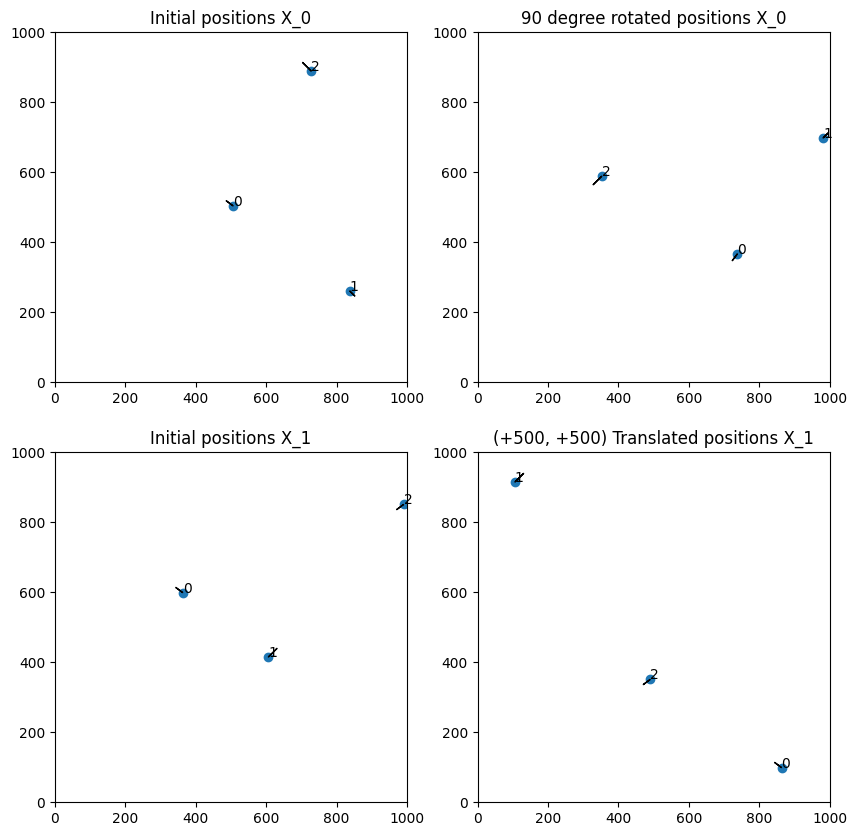

In [83]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].set_title("Initial positions X_0")
ax[0, 1].set_title("90 degree rotated positions X_0")
ax[1, 0].set_title("Initial positions X_1")
ax[1, 1].set_title("(+500, +500) Translated positions X_1")

x_0 = np.load("../data/boids/raw_equiv/boids_rotation_equivariant_trajectory_0.npy")
Rx_0 = np.load("../data/boids/raw_equiv/boids_rotation_equivariant_trajectory_1.npy")
x_1 = np.load("../data/boids/raw_equiv/boids_translation_equivariant_trajectory_0.npy")
Tx_1 = np.load("../data/boids/raw_equiv/boids_translation_equivariant_trajectory_1.npy")

print(x_0.shape)
pos_0 = x_0[0, :, :2]
pos_1 = x_1[0, :, :2]
pos_r0 = Rx_0[0, :, :2]
pos_t1 = Tx_1[0, :, :2]

ax[0, 0].scatter(pos_0[:, 0], pos_0[:, 1])
ax[0, 1].scatter(pos_r0[:, 0], pos_r0[:, 1])
ax[1, 0].scatter(pos_1[:, 0], pos_1[:, 1])
ax[1, 1].scatter(pos_t1[:, 0], pos_t1[:, 1])

print("Initial positions")
print(pos_0[:, 0], pos_0[:, 1])
print("90 degree rotated positions")
print(pos_r0[:, 0], pos_r0[:, 1])
print("Initial positions")
print(pos_1[:, 0], pos_1[:, 1])
print("Translated positions")
print(pos_t1[:, 0], pos_t1[:, 1])

velocity_x0 = x_0[0, :, 2:]
velocity_x1 = x_1[0, :, 2:]
velocity_r0 = Rx_0[0, :, 2:]
velocity_t1 = Tx_1[0, :, 2:]

# Draw arrows for the velocities
for i in range(pos_0.shape[0]):
    ax[0, 0].arrow(pos_0[i, 0], pos_0[i, 1], velocity_x0[i, 0]*5, velocity_x0[i, 1]*5)
    ax[0, 1].arrow(pos_r0[i, 0], pos_r0[i, 1], velocity_r0[i, 0]*5, velocity_r0[i, 1]*5)
    ax[1, 0].arrow(pos_1[i, 0], pos_1[i, 1], velocity_x1[i, 0]*5, velocity_x1[i, 1]*5)
    ax[1, 1].arrow(pos_t1[i, 0], pos_t1[i, 1], velocity_t1[i, 0]*5, velocity_t1[i, 1]*5)

# Add text to each position
for i in range(pos_0.shape[0]):
    ax[0, 0].text(pos_0[i, 0], pos_0[i, 1], f"{i}")
    ax[0, 1].text(pos_r0[i, 0], pos_r0[i, 1], f"{i}")
    ax[1, 0].text(pos_1[i, 0], pos_1[i, 1], f"{i}")
    ax[1, 1].text(pos_t1[i, 0], pos_t1[i, 1], f"{i}")

# set xlim, ylim to 0, 1000 for all subplots
for i in range(2):
    for j in range(2):
        ax[i, j].set_xlim(0, 1000)
        ax[i, j].set_ylim(0, 1000)
plt.show()

Now if we run both models on this data, we will see that the E(n) model produces equivariant prediction for BOTH datasets, and the Translational equivariant model is only guaranteed to be equivariant to translations*

tensor([[0.8591, 0.1019],
        [0.1109, 0.9203],
        [0.4859, 0.3479]], device='cuda:0', grad_fn=<AddBackward0>)


(0.0, 1000.0)

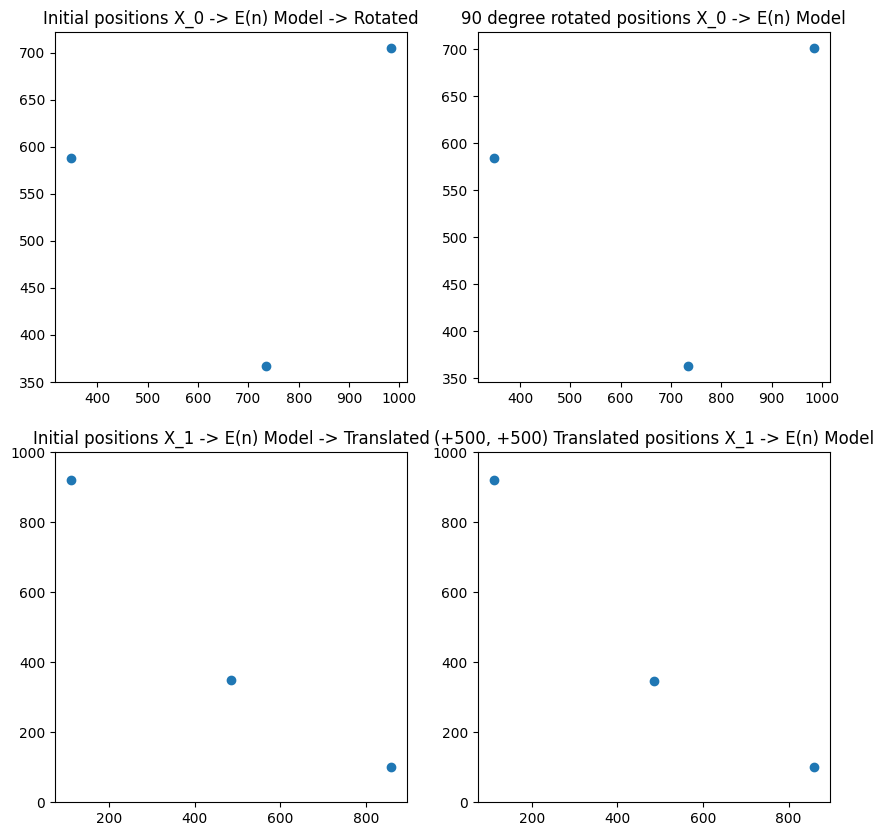

In [162]:
# FIRST we'll do the E(n) model

En_model = En_GNN(2, 64, 2, 2, num_nodes=3).to(device)
En_model.load_state_dict(torch.load("../models/01-En-Model.pt"))

def get_En_data(trajectory):
    pos = torch.tensor(trajectory[0, :, :2] / 1000, dtype=torch.float).to(device)
    vel = torch.tensor(trajectory[0, :, 2:] / 1000, dtype=torch.float).to(device)
    next_pos = torch.tensor(trajectory[1, :, :2] / 1000, dtype=torch.float).to(device)
    next_vel = torch.tensor(trajectory[1, :, 2:] / 1000, dtype=torch.float).to(device)
    edge_index = torch.tensor([[i, j] for i in range(pos.shape[0]) for j in range(pos.shape[0]) if i != j], dtype=torch.long).t().contiguous().to(device)
    return Data(x=(pos, vel), y=(next_pos, next_vel), edge_index=edge_index).to(device)

data_x0 = get_En_data(x_0)
data_x1 = get_En_data(x_1)
data_r0 = get_En_data(Rx_0)
data_t1 = get_En_data(Tx_1)

pred_x0 = En_model(data_x0)
pred_x1 = En_model(data_x1)
pred_r0 = En_model(data_r0)
pred_t1 = En_model(data_t1)

rotation_matrix = torch.tensor([[0, 1], [-1, 0]], dtype=torch.float).to(device)

def rotate_positions(positions, rotation_matrix, L=1):
    centroid = torch.mean(positions, dim=0)
    positions = positions - centroid
    positions = torch.matmul(positions, rotation_matrix)
    positions = positions + centroid
    return np.mod(positions.cpu().detach().numpy(), L)

def translate_positions(positions, translation_vector, L=1):
    return np.mod((positions + translation_vector).cpu().detach().numpy(), L)

def rotate_velocities(velocities, rotation_matrix):
    return torch.matmul(velocities, rotation_matrix)

rotated_pos_x0 = rotate_positions(pred_x0[0], rotation_matrix) 
rotated_vel_x0 = rotate_velocities(pred_x0[1], rotation_matrix)

translated_pos_x1 = translate_positions(pred_x1[0], torch.tensor([0.5, 0.5], dtype=torch.float).to(device))
translated_vel_x1 = pred_x1[1]

print(pred_t1[0])

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].set_title("Initial positions X_0 -> E(n) Model -> Rotated")
ax[0, 1].set_title("90 degree rotated positions X_0 -> E(n) Model")
ax[1, 0].set_title("Initial positions X_1 -> E(n) Model -> Translated")
ax[1, 1].set_title("(+500, +500) Translated positions X_1 -> E(n) Model")

ax[0, 0].scatter(rotated_pos_x0[:, 0] * 1000, rotated_pos_x0[:, 1] * 1000)
ax[0, 1].scatter((pred_r0[0][:, 0] * 1000).cpu().detach().numpy(), (pred_r0[0][:, 1] * 1000).cpu().detach().numpy())
ax[1, 0].scatter(translated_pos_x1[:, 0] * 1000, translated_pos_x1[:, 1] * 1000)
ax[1, 1].scatter((pred_t1[0][:, 0] * 1000).cpu().detach().numpy(), (pred_t1[0][:, 1] * 1000).cpu().detach().numpy())

ax[1, 0].set_ylim(0, 1000)
ax[1, 1].set_ylim(0, 1000)


As we can see from the above plot, the E(n) GNN model indeed produces predictions that are equivariant to the E(n) transformations.

Now to investigate the Translational equivariant model:

C:\Users\alec\AppData\Local\Temp\ipykernel_7244\1321645131.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rotated_pred_pos_x0 = rotate_positions(torch.tensor(pred_pos_x0, dtype=torch.float).to(device), rotation_matrix, L=1000)
C:\Users\alec\AppData\Local\Temp\ipykernel_7244\1321645131.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  translated_pred_pos_x1 = translate_positions(torch.tensor(pred_pos_x1, dtype=torch.float).to(device), torch.tensor([500, 500], dtype=torch.float).to(device), L=1000)


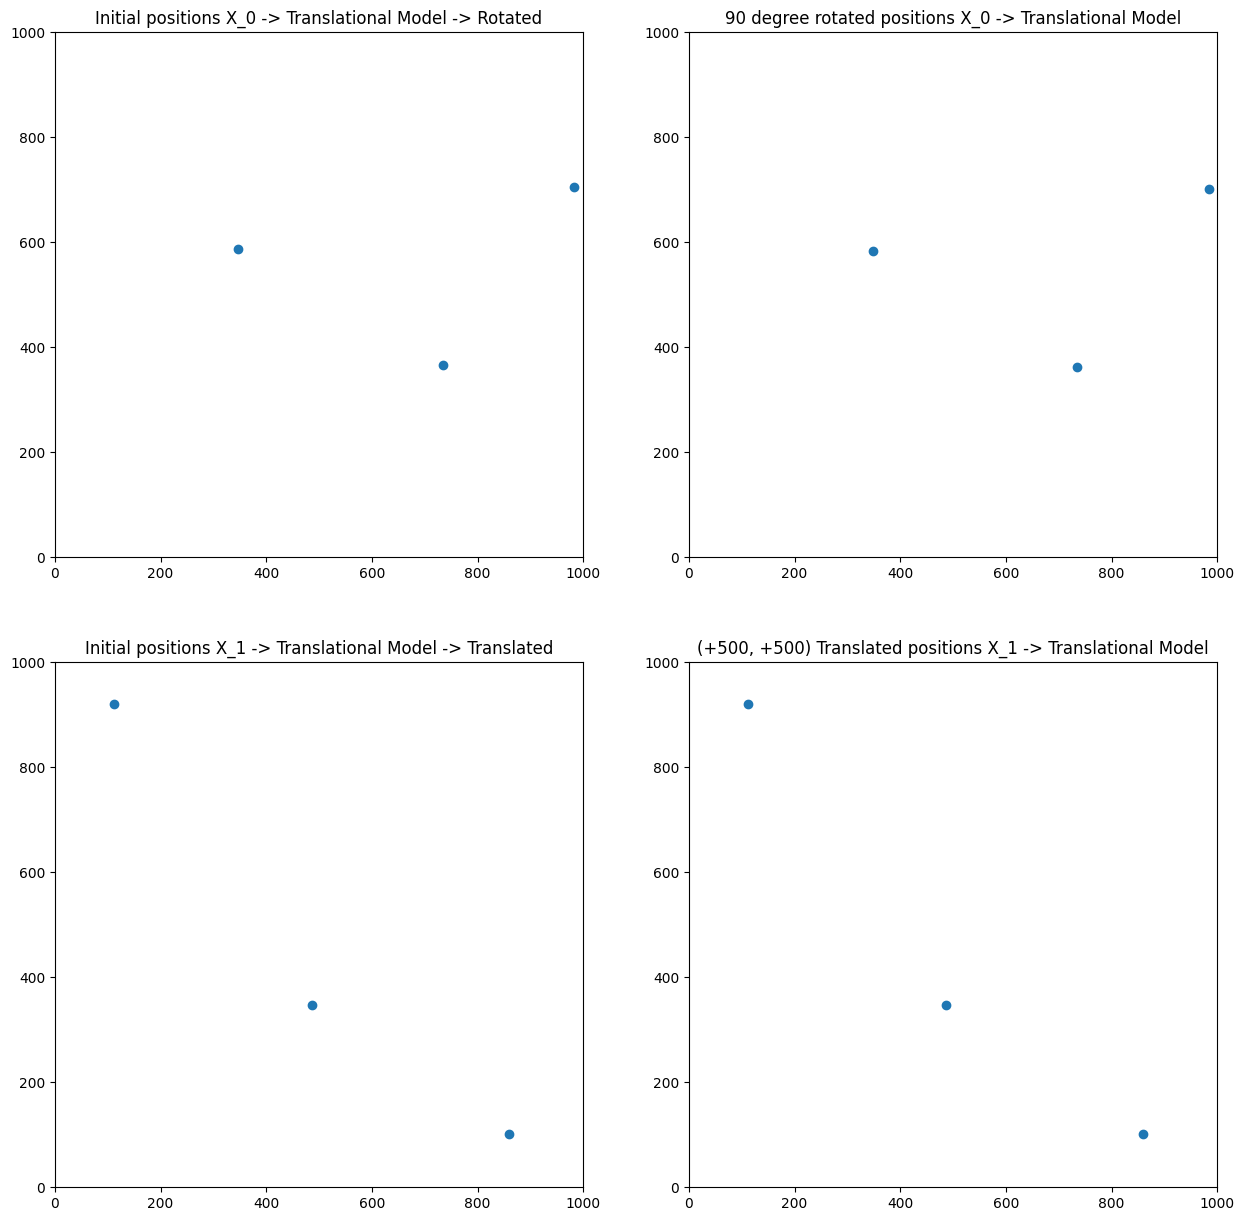

In [165]:
def pbc_distance(x1, x2, y1, y2, L=1000):
    """
    Compute the distance between two points with periodic boundary conditions

    Args:
        x1 (float): x coordinate of point 1
        x2 (float): x coordinate of point 2
        y1 (float): y coordinate of point 1
        y2 (float): y coordinate of point 2
        
    Returns:
        float: Distance between the two points
    """
    dx = torch.abs(x1 - x2)
    dy = torch.abs(y1 - y2)
    dx = torch.min(dx, L - dx)
    dy = torch.min(dy, L - dy)
    return torch.sqrt(dx**2 + dy**2)

def get_trans_data(trajectory):
    """
    Get the data for the translational model

    Args:
        trajectory: np.array of shape (2, N, 4)
    """
    # X is the current state: (Velocity x, Velocity y)
    # Y is the next state: (Delta Pos x, Delta Pos y, Delta Velocity x, Delta Velocity y)
    x = torch.tensor(trajectory[0], dtype=torch.float)
    y_temp = torch.tensor(trajectory[1], dtype=torch.float)
    # Right now y is (position x, position y, velocity x, velocity y) for the next timestep
    # However, we want delta position and delta velocity
    # Luckily, the delta poisition is just the velocity from the next timestep, and the delta velocity is the acceleration
    # So we can just take the last two elements of y to get the delta velocity
    # First we copy the last two columns of y to the first two columns of y
    y = y_temp.clone()
    y[:, :2] = y_temp[:, 2:]
    # Then we calculate the acceleration
    y[:, 2:] = y_temp[:, 2:] - x[:, 2:]
    edge_index = torch.tensor([[i, j] for i in range(trajectory.shape[1]) for j in range(trajectory.shape[1]) if i != j], dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor([[pbc_distance(x[i, 0], x[j, 0], x[i, 1], x[j, 1])] for i in range(trajectory.shape[1]) for j in range(trajectory.shape[1]) if i != j], dtype=torch.float).t().contiguous()
    initial_pos = x[:, :2]
    x = x[:, 2:]
    
    return Data(x=x, y=y, edge_index=edge_index, edge_attr=edge_attr).to(device), initial_pos

data_x0, initial_x0 = get_trans_data(x_0)
data_x1, initial_x1 = get_trans_data(x_1)
data_r0, initial_r0 = get_trans_data(Rx_0)
data_t1, initial_t1 = get_trans_data(Tx_1)

pred_x0 = translational_equivariant_model(data_x0)
pred_x1 = translational_equivariant_model(data_x1)
pred_r0 = translational_equivariant_model(data_r0)
pred_t1 = translational_equivariant_model(data_t1)

pred_pos_x0 = np.mod(initial_x0 + pred_x0[:, :2].cpu().detach().numpy(),1000)
pred_pos_x1 = np.mod(initial_x1 + pred_x1[:, :2].cpu().detach().numpy(),1000)
pred_pos_r0 = np.mod(initial_r0 + pred_r0[:, :2].cpu().detach().numpy(),1000)
pred_pos_t1 = np.mod(initial_t1 + pred_t1[:, :2].cpu().detach().numpy(),1000)

# Rotate pred_pos_x0
rotated_pred_pos_x0 = rotate_positions(torch.tensor(pred_pos_x0, dtype=torch.float).to(device), rotation_matrix, L=1000)
# Translate pred_pos_x1
translated_pred_pos_x1 = translate_positions(torch.tensor(pred_pos_x1, dtype=torch.float).to(device), torch.tensor([500, 500], dtype=torch.float).to(device), L=1000)

fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax[0, 0].set_title("Initial positions X_0 -> Translational Model -> Rotated")
ax[0, 1].set_title("90 degree rotated positions X_0 -> Translational Model")
ax[1, 0].set_title("Initial positions X_1 -> Translational Model -> Translated")
ax[1, 1].set_title("(+500, +500) Translated positions X_1 -> Translational Model")

ax[0, 0].scatter(rotated_pred_pos_x0[:, 0], rotated_pred_pos_x0[:, 1])
ax[0, 1].scatter(pred_pos_r0[:, 0], pred_pos_r0[:, 1])
ax[1, 0].scatter(translated_pred_pos_x1[:, 0], translated_pred_pos_x1[:, 1])
ax[1, 1].scatter(pred_pos_t1[:, 0], pred_pos_t1[:, 1])


# set xlim, ylim=1000 for all subplots
for i in range(2):
    for j in range(2):
        ax[i, j].set_xlim(0, 1000)
        ax[i, j].set_ylim(0, 1000)

Interestingly, the translational model **does** learn to predict something similar for the rotated dataset. The learning task was possibly simple enough that the E(n)/Translational models work similarly.

One thing to note, is that we only tested the models on one sample. It could be that the Translational model's predictions may not be equivariant to rotations in more chaotic states, or it may break for unseen inputs. 

As you know, for more complex learning tasks, incorporating equivariances in deep dynamics models has been shown to greatly improve sample efficiency, parameter efficiency, and accuracy [1].

So they are still cool `:)`

# References

[1] Minartz, K., Poels, Y., Koop, S., & Menkovski, V. (2023). Equivariant Neural Simulators for Stochastic Spatiotemporal Dynamics. https://openreview.net/forum?id=CCVsGbhFdj

[2] Reynolds, C. W. (1987) Flocks, Herds, and Schools: A Distributed Behavioral Model, in Computer Graphics, 21(4) (SIGGRAPH '87 Conference Proceedings) pages 25-34.

[3] Satorras, V. G., Hoogeboom, E., & Welling, M. (2021, July). E (n) equivariant graph neural networks. In International conference on machine learning (pp. 9323-9332). PMLR.